Malha de referência (h=0.0001): 10001 pontos

Resolvendo EDO com diferentes passos de tempo...
Passo h=0.8: avaliado em 10001 pontos
Passo h=0.4: avaliado em 10001 pontos
Passo h=0.2: avaliado em 10001 pontos
Passo h=0.1: avaliado em 10001 pontos

Criando solução de referência...
Referência (h=0.0001): 10001 pontos

Calculando erros...


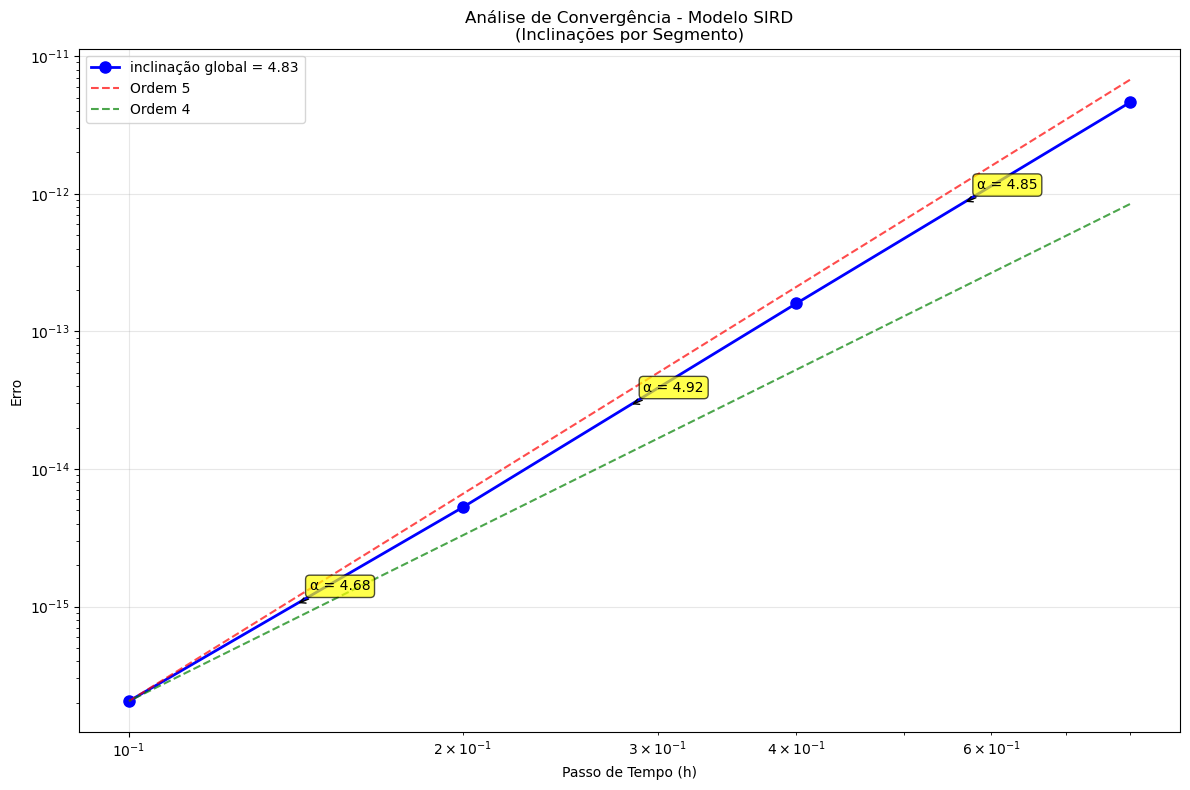


RELATÓRIO DE ERROS E CONVERGÊNCIA

h=0.8:
  RMSE - S: 1.42e-11
  RMSE - I: 4.61e-12
  RMSE - R: 4.82e-12
  RMSE - D: 4.82e-12

h=0.4:
  RMSE - S: 4.70e-13
  RMSE - I: 1.60e-13
  RMSE - R: 1.66e-13
  RMSE - D: 1.66e-13

h=0.2:
  RMSE - S: 2.42e-14
  RMSE - I: 5.26e-15
  RMSE - R: 5.44e-15
  RMSE - D: 5.44e-15

h=0.1:
  RMSE - S: 3.22e-14
  RMSE - I: 2.06e-16
  RMSE - R: 1.90e-16
  RMSE - D: 1.90e-16

Inclinação global da convergência: 4.83

Inclinações por segmento:
  Segmento 1 (h=0.80 → h=0.40): α = 4.85
  Segmento 2 (h=0.40 → h=0.20): α = 4.92
  Segmento 3 (h=0.20 → h=0.10): α = 4.68


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Definir o modelo SIR
def sir(t, y, beta=0.3, gamma=0.1, sigma=0.1):
  
    S, I, R, D = y
    N = S + I + R + D  # População total
    
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - sigma * I
    dRdt = gamma * I
    dDdt = sigma * I  # Mortes proporcionais aos infectados
    
    return [dSdt, dIdt, dRdt, dDdt]

# Condições iniciais
S0, I0, R0, D0 = 999, 1, 0, 0  # População inicial
t_span = (0, 1)  # Intervalo de tempo

# Definir malha de referência com passo 0.0001
h_ref = 0.0001
t_common = np.arange(t_span[0], t_span[1] + h_ref, h_ref)
print(f"Malha de referência (h=0.0001): {len(t_common)} pontos")

# Passos de tempo para comparar
steps = [0.8, 0.4, 0.2, 0.1]

# Dicionário para armazenar as soluções
solutions = {}

print("\nResolvendo EDO com diferentes passos de tempo...")

# Resolver com diferentes passos mas avaliando na malha de referência
for h in steps:
    sol_tmp = solve_ivp(sir, t_span, [S0, I0, R0, D0], t_eval=t_common, 
                       method='RK45', max_step=h)
    solutions[f'h={h}'] = sol_tmp
    print(f"Passo h={h}: avaliado em {len(sol_tmp.t)} pontos")

# Solução de referência com passo muito pequeno (0.0001)
print("\nCriando solução de referência...")
sol_ref = solve_ivp(sir, t_span, [S0, I0, R0, D0], t_eval=t_common, 
                   method='RK45', max_step=h_ref)
print(f"Referência (h={h_ref}): {len(sol_ref.t)} pontos")

# # Função para calcular erros
# def calculate_errors(sol, sol_ref):
#     errors = {}
    
#     for i, var in enumerate(['S', 'I', 'R', 'D']):
#         diff = sol.y[i] - sol_ref.y[i]
#         errors[f'{var}_rmse'] = np.linalg.norm(diff, 2, axis=1)
    
#     return errors

# Função para calcular erros
def calculate_errors(sol, sol_ref):
    errors = {}
    
    for i, var in enumerate(['S', 'I', 'R', 'D']):
        diff = sol.y[i] - sol_ref.y[i]
        errors[f'{var}_rmse'] = np.linalg.norm(diff, 2) / len(diff)
    
    return errors


error_analysis = {}
for name, sol in solutions.items():
    error_analysis[name] = calculate_errors(sol, sol_ref)


# Função para calcular inclinação entre dois pontos consecutivos
def calculate_segment_slopes(step_values, rmse_values):

    slopes = []
    for i in range(len(step_values) - 1):
        h1, h2 = step_values[i], step_values[i + 1]
        e1, e2 = rmse_values[i], rmse_values[i + 1]
        
        # Inclinação no espaço log-log
        slope = (np.log10(e2) - np.log10(e1)) / (np.log10(h2) - np.log10(h1))
        slopes.append(slope)
        
    return slopes

# Plot único: Análise de convergência com inclinações por segmento
plt.figure(figsize=(12, 8))

step_values = [0.8, 0.4, 0.2, 0.1]
rmse_values = [error_analysis[f'h={h}']['I_rmse'] for h in step_values]

# Calcular inclinações dos segmentos
segment_slopes = calculate_segment_slopes(step_values, rmse_values)

# Calcular a inclinação global (regressão linear no espaço log-log)
log_steps = np.log10(step_values)
log_rmse = np.log10(rmse_values)
global_slope = np.polyfit(log_steps, log_rmse, 1)[0]

plt.loglog(step_values, rmse_values, 'bo-', linewidth=2, markersize=8, 
           label=f'inclinação global = {global_slope:.2f}')

# Adicionar anotações com inclinações dos segmentos
for i in range(len(segment_slopes)):
    h_mid = np.sqrt(step_values[i] * step_values[i + 1])  # Média geométrica
    e_mid = np.sqrt(rmse_values[i] * rmse_values[i + 1])  # Média geométrica
    
    plt.annotate(f'α = {segment_slopes[i]:.2f}', 
                xy=(h_mid, e_mid), xytext=(10, 10), 
                textcoords='offset points', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Linha de referência para convergência de 2ª ordem
ref_line = rmse_values[-1] * (np.array(step_values) / step_values[-1])**5
plt.loglog(step_values, ref_line, 'r--', alpha=0.7, label='Ordem 5')

# Linha de referência para convergência de 4ª ordem
ref_line_4 = rmse_values[-1] * (np.array(step_values) / step_values[-1])**4
plt.loglog(step_values, ref_line_4, 'g--', alpha=0.7, label='Ordem 4')

plt.xlabel('Passo de Tempo (h)')
plt.ylabel('Erro')
plt.title('Análise de Convergência - Modelo SIRD\n(Inclinações por Segmento)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


for name, errors in error_analysis.items():
    print(f"\n{name}:")
    print(f"  RMSE - S: {errors['S_rmse']:.2e}")
    print(f"  RMSE - I: {errors['I_rmse']:.2e}")
    print(f"  RMSE - R: {errors['R_rmse']:.2e}")
    print(f"  RMSE - D: {errors['D_rmse']:.2e}")

print(f"\nInclinação global da convergência: {global_slope:.2f}")

for i, slope in enumerate(segment_slopes):
    print(f"  Segmento {i+1} (h={step_values[i]:.2f} → h={step_values[i+1]:.2f}): α = {slope:.2f}")


In [4]:
print(sol_tmp)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04 ...  9.999e-01  1.000e+00]
        y: [[ 9.990e+02  9.990e+02 ...  9.987e+02  9.987e+02]
            [ 1.000e+00  1.000e+00 ...  1.105e+00  1.105e+00]
            [ 0.000e+00  1.000e-05 ...  1.051e-01  1.052e-01]
            [ 0.000e+00  1.000e-05 ...  1.051e-01  1.052e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 68
     njev: 0
      nlu: 0
